In [1]:
#This code gives you the stats for all models in the BCS_CNN folder, currently, it gives: Accuracy, precision, recall, F1 score, and MSE

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image as pil_image
import imageio
import tensorflow
import sklearn.metrics
import itertools
physical_devices = tensorflow.config.experimental.list_physical_devices('GPU')
tensorflow.config.experimental.set_memory_growth(physical_devices[0], True)
from keras.applications.vgg16 import preprocess_input
from astropy.io import fits
import skimage.transform
import keras
from keras.layers import Input
import keras.applications
from keras.models import Model
from keras.layers import Dense, Flatten, Dropout, Conv2D, ReLU, concatenate, MaxPool2D, AvgPool2D
import glob
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from tensorflow.keras.optimizers import Adam
import sklearn.metrics
import csv

model_type = 'SqueezeNet'


def normalize_Xtrain(X_train):
    mn = []
    mx = []
    Xn_train = np.zeros(np.shape(X_train))
    X_norm = np.zeros(np.shape(X_train))
    for i in range(len(X_train[0, ::])):
        mn.append(np.min(X_train[::, i]))
        Xn_train[::, i] = X_train[::, i] - mn[i]
    for i in range(len(X_train[0, ::])):
        mx.append(np.max(Xn_train[::, i]))
        if mx[i] == 0:
            X_norm[::, i] = 0
        if mx[i] != 0:
            X_norm[::, i] = Xn_train[::, i]/mx[i]
            
    return X_norm, mx, mn

with open(model_type+'_stats.csv', 'w', newline='') as file:
    writer = csv.writer(file, delimiter=',', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(['Model', 'Accuracy', 'Precision', 'Weighted Precision', 'Recall', 'Weighted Recall', 'F1 Score', 'Weighted F1 Score', 'MSE'])

with open(model_type+'_stats_within_1.csv', 'w', newline='') as file:
    writer = csv.writer(file, delimiter=',', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(['Model', 'Accuracy', 'Precision', 'Weighted Precision', 'Recall', 'Weighted Recall', 'F1 Score', 'Weighted F1 Score', 'MSE'])

DE_ALL
SqueezeNet_DE_ALL
test_data_DE_ALL.csv
Found 530 validated image filenames belonging to 5 classes.
Beginning of results for  SqueezeNet_DE_ALL -------------------------------------------------------

The accuracy of  SqueezeNet_DE_ALL  is:  0.8452830188679246

Model precision is:  0.8337315354671746
Model weighted precision is:  0.853489799827542

Model recall is:  0.7936474295424701
Model weighted recall is:  0.8452830188679246

Model f1_score is:  0.8086842454659908
Model weighted f1_score is:  0.8441405059851587

Model MSE is:  0.30754716981132074

****Error within 1 results starts now****

The accuracy of  SqueezeNet_DE_ALL  within 1 is:  0.9584905660377359

Model unweighted precision is:  0.9077911259245178
Model weighted precision is:  0.9598784148349659

Model unweighted recall is:  0.9114104872835467
Model weighted recall is:  0.9584905660377359

Model unweighted f1_score is:  0.9087065705565165
Model weighted f1_score is:  0.9588274817317981

DE_LACO
SqueezeNet_DE_LACO


<ipython-input-2-62988bc2df25>:74: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(10,10))


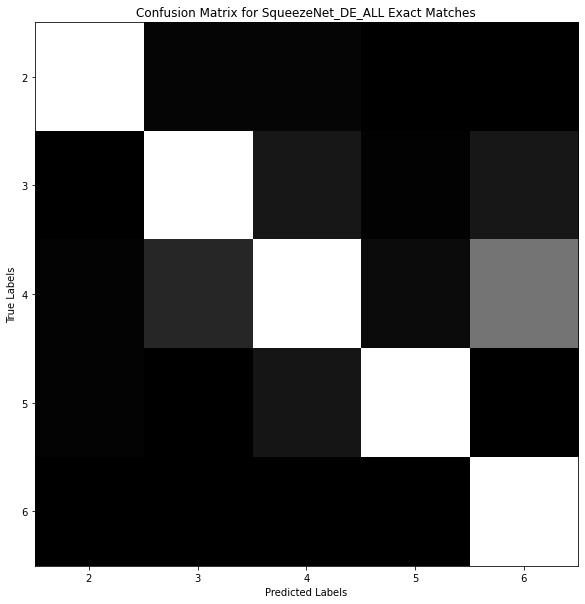

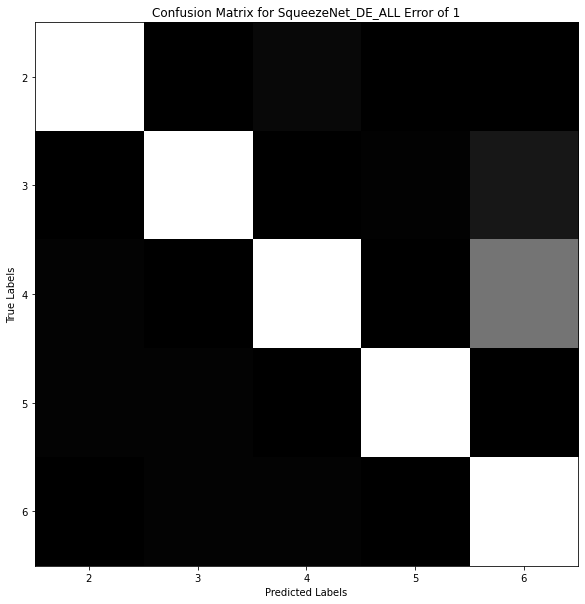

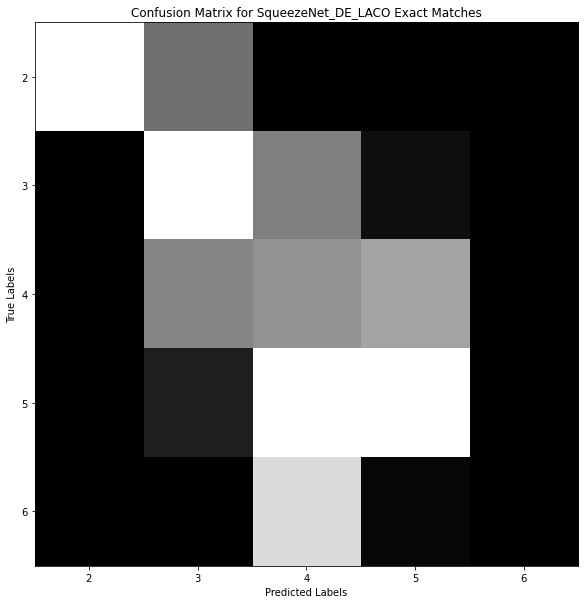

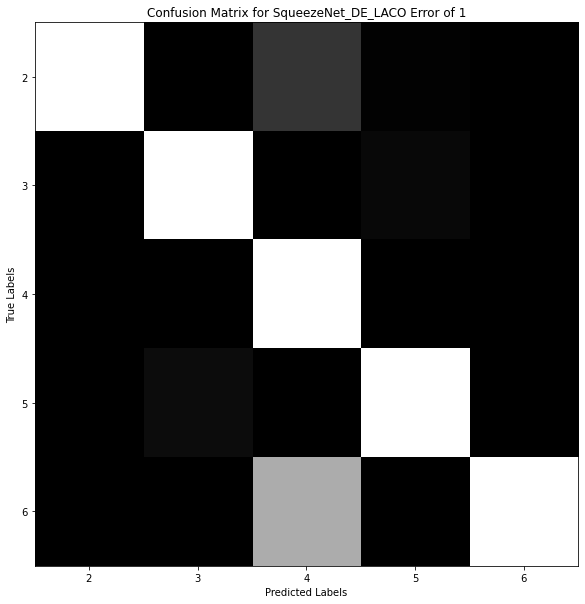

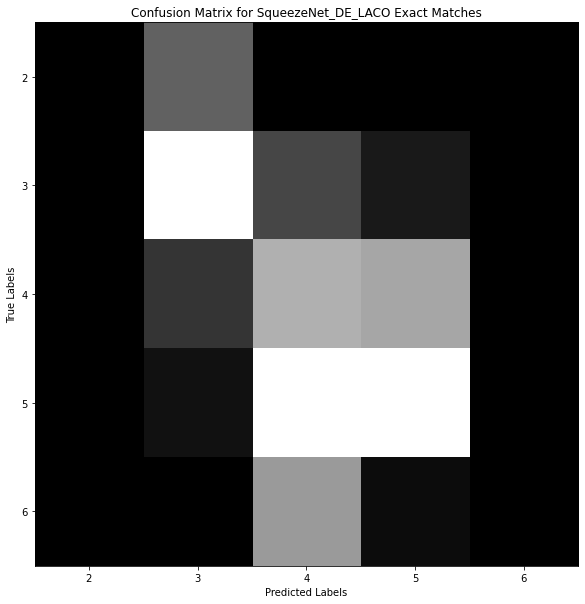

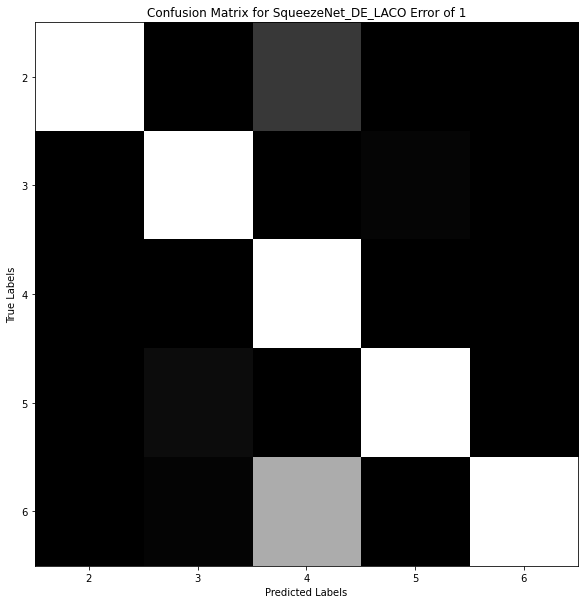

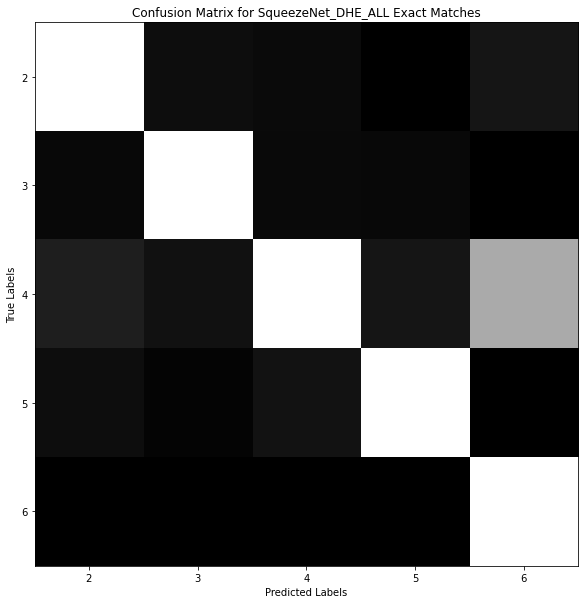

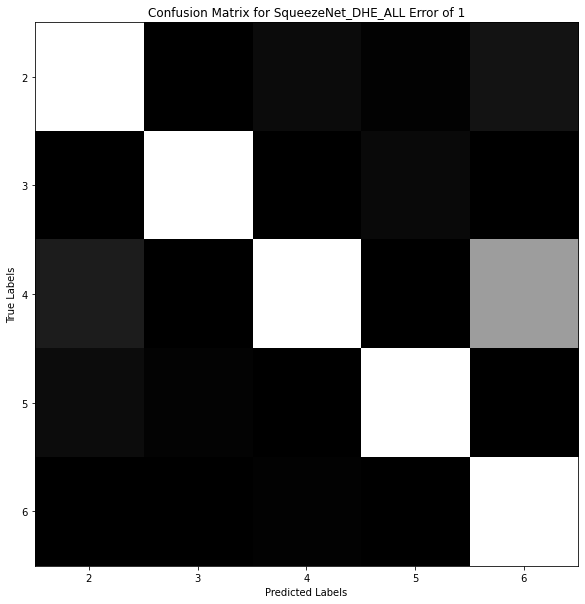

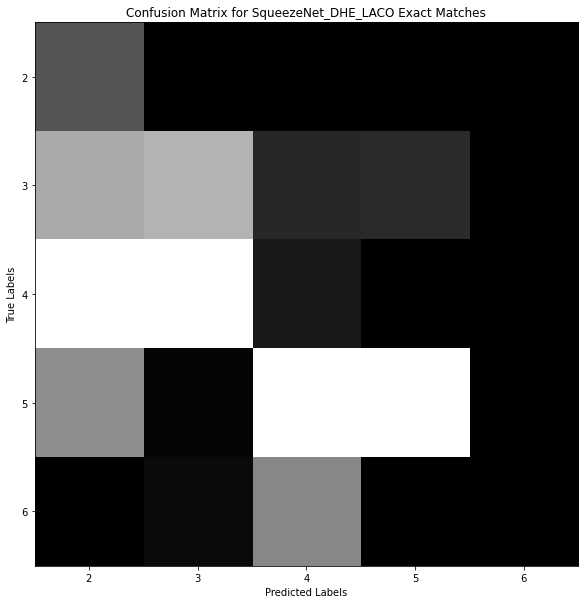

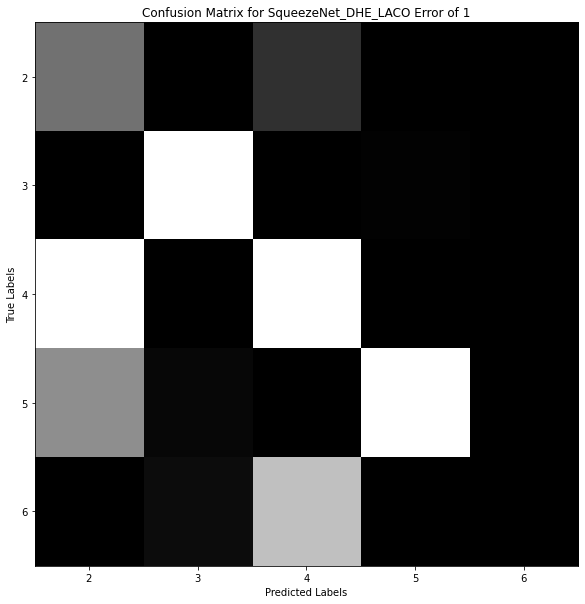

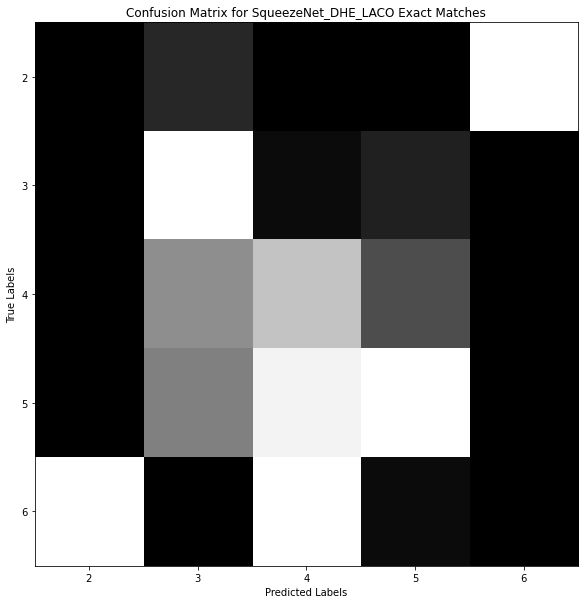

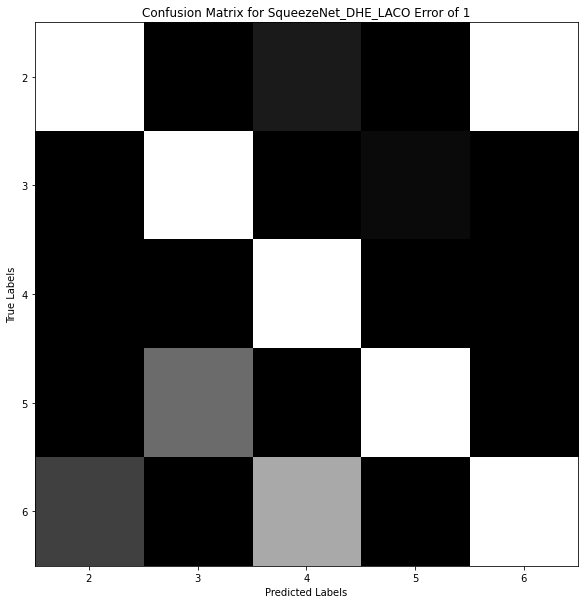

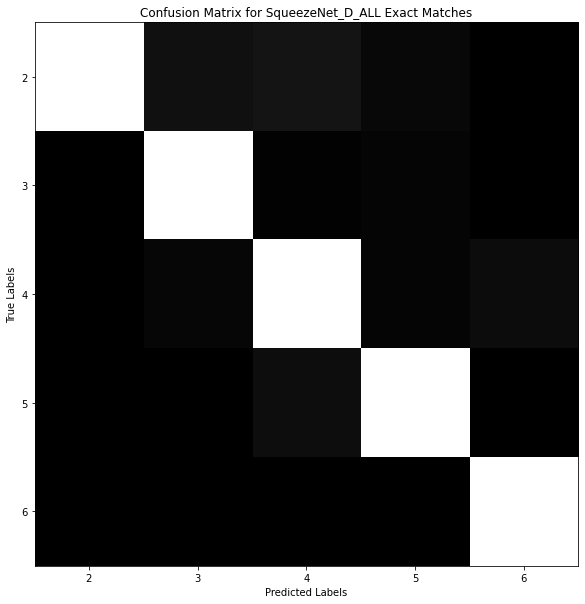

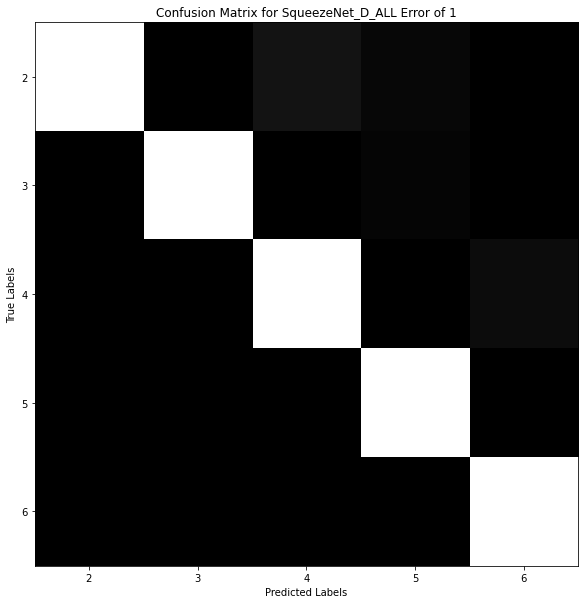

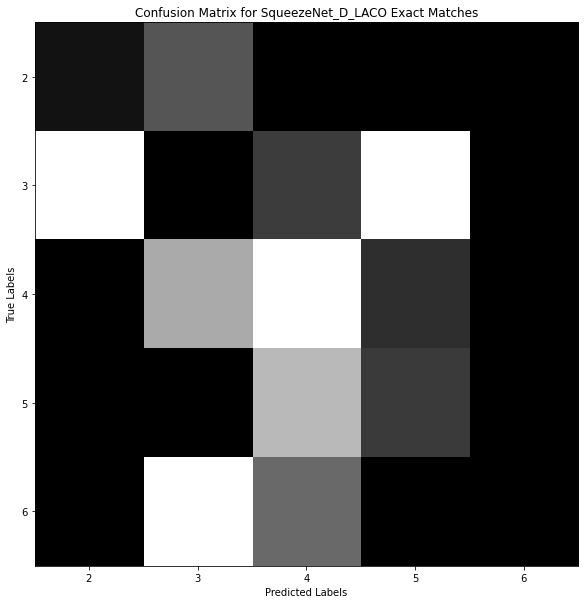

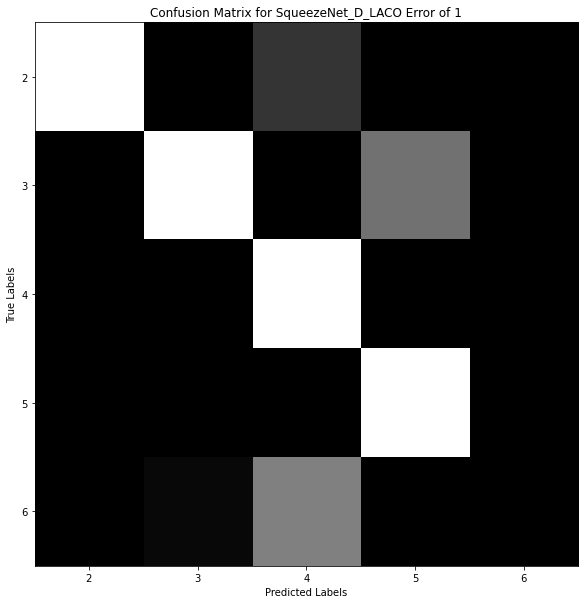

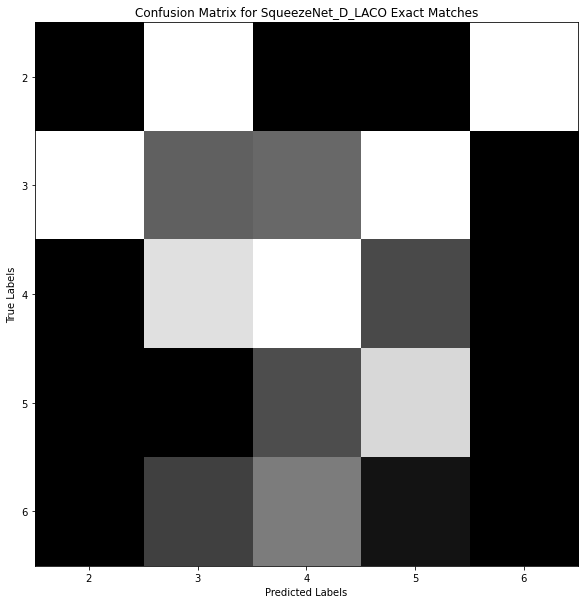

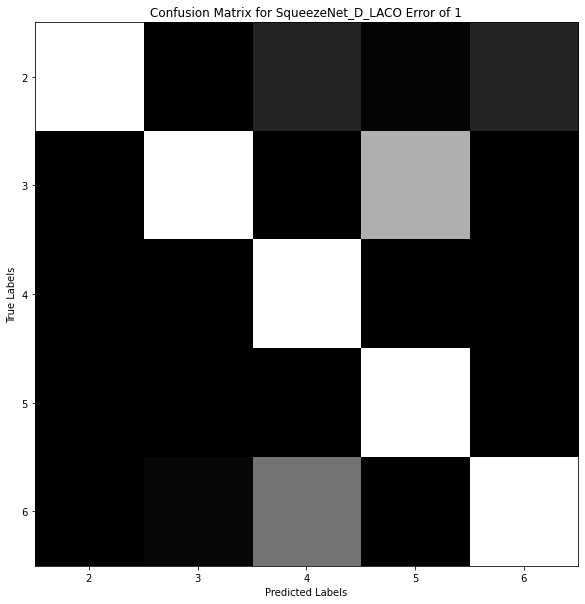

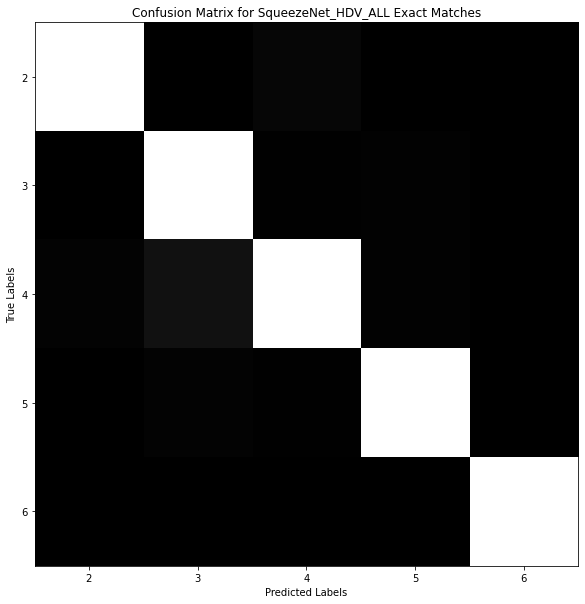

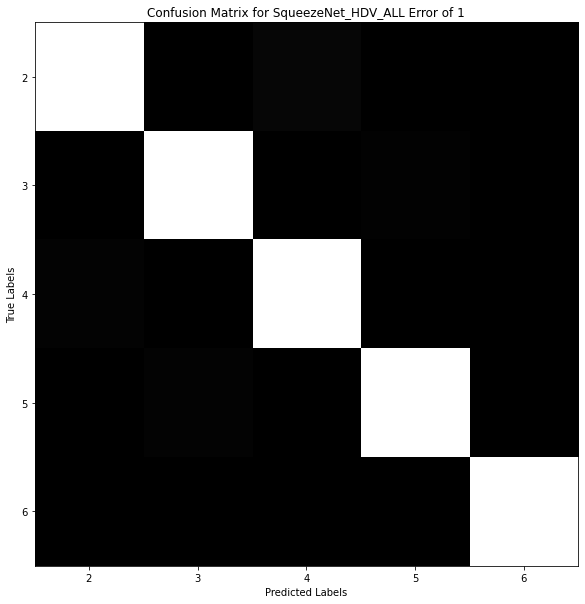

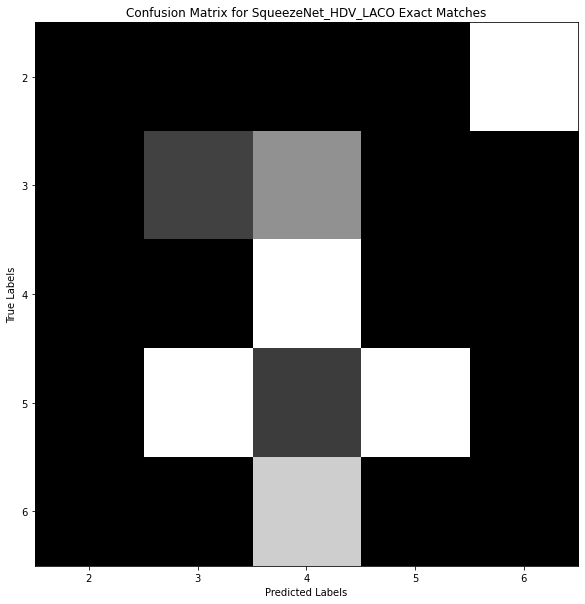

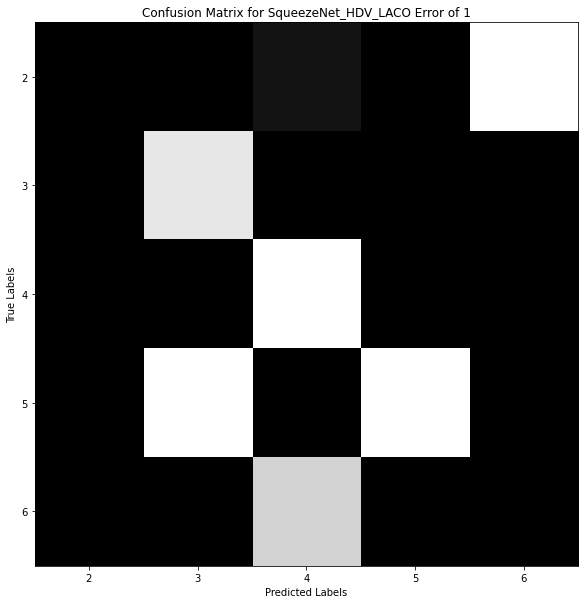

In [2]:
model_names = glob.glob('BCS_CNN\\' + model_type + '\\*')
for model_name in model_names:
    model = load_model(model_name)
    # data_set_type = model_name[len('BCS_CNN\VGG16\VGG16_'):-8] #For VGG16
    # name = str(model_name[len('BCS_CNN\VGG16\\'):-8]) #For VGG16
    # data_set_type = model_name[len('BCS_CNN\SqueezeNet\SqueezeNet_'):-8] #for Squeezenet
    # name = str(model_name[len('BCS_CNN\SqueezeNet\\'):-8]) #For SqueezeNet
    data_set_type = model_name[len('BCS_CNN/' + model_type + '/' + model_type + '_'):-8]
    name = str(model_name[len('BCS_CNN/' + model_type + '/'):-8]) 
    print(data_set_type)
    print(name)
    test_data = 'test_data_' + data_set_type + '.csv'
    print(test_data)

    test_df = pd.read_csv(test_data,dtype=str)
    #test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
    test_datagen = ImageDataGenerator(fill_mode = "reflect", data_format = "channels_last")
    test_generator = test_datagen.flow_from_dataframe(dataframe=test_df,\
                                                directory = '',\
                                                xcol='filename',ycol='class',\
                                                target_size=(224,224), color_mode='rgb',\
                                                batch_size=128, class_mode='categorical',\
                                                shuffle=False)

    # train_data = 'train_data_' + data_set_type + '.csv'
    # train_df = pd.read_csv(train_data,dtype=str)
    #train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
    # train_datagen = ImageDataGenerator(fill_mode = "reflect", data_format = "channels_last")
    # train_generator = train_datagen.flow_from_dataframe(dataframe=train_df,\
    #                                                 directory='',\
    #                                                 xcol='filename',y_col='class',\
    #                                                 target_size=(224,224), color_mode='rgb',\
    #                                                 batch_size=128, class_mode='categorical',\
    #                                                 shuffle=False)


    adam_opt = Adam(learning_rate=0.001)
    model.compile(loss='categorical_crossentropy', optimizer=adam_opt,\
               metrics=['categorical_accuracy'])
    Y_test_hat=model.predict(test_generator)
    y_test_hat=Y_test_hat.argmax(axis=-1)+2

    # Y_train_hat=model.predict(train_generator)
    # y_train_hat=Y_train_hat.argmax(axis=-1)+2



    y_test = test_df['class']
    y_test = [int(i) for i in y_test]

    # y_train = train_df['class']
    # y_train = [int(i) for i in y_train]

    print('Beginning of results for ', name, '-------------------------------------------------------')
    print()

    con_matrix = sklearn.metrics.confusion_matrix(y_test,y_test_hat)
    acc=np.diag(con_matrix).sum().astype(float)/con_matrix.sum()

    # con_matrix_train = sklearn.metrics.confusion_matrix(y_train,y_train_hat)
    # acc_train=np.diag(con_matrix_train).sum().astype(float)/con_matrix_train.sum()


    print('The accuracy of ', name,' is: ', acc)
    print()
    # print('The train accuracy of ', name,' is: ', acc_train)
    # print()

    min = np.min(con_matrix)
    max = np.max(con_matrix)
    temp_mat = con_matrix - min
    temp_mat = con_matrix/max

    plt.figure(figsize=(10,10))
    plt.imshow(normalize_Xtrain(con_matrix)[0], cmap='gray')
    plt.title('Confusion Matrix for '+ name + ' Exact Matches')
    plt.xticks(list(range(len(['2', '3', '4', '5', '6']))), ['2', '3', '4', '5', '6'])
    plt.yticks(list(range(len(['2', '3', '4', '5', '6']))), ['2', '3', '4', '5', '6'])
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')

    #Metrics
    precision = sklearn.metrics.precision_score(y_test,y_test_hat, average='macro', zero_division=1)
    print('Model precision is: ', precision)
    precision_weighted = sklearn.metrics.precision_score(y_test,y_test_hat, average='weighted', zero_division=1)
    print('Model weighted precision is: ', precision_weighted)
    print()

    recall = sklearn.metrics.recall_score(y_test,y_test_hat, average='macro')
    print('Model recall is: ', recall)
    recall_weighted = sklearn.metrics.recall_score(y_test,y_test_hat, average='weighted')
    print('Model weighted recall is: ', recall_weighted)
    print()

    f1_score = sklearn.metrics.f1_score(y_test,y_test_hat, average='macro')
    print('Model f1_score is: ', f1_score)
    f1_score_weighted = sklearn.metrics.f1_score(y_test,y_test_hat, average='weighted')
    print('Model weighted f1_score is: ', f1_score_weighted)
    print()


    MSE = sklearn.metrics.mean_squared_error(y_test,y_test_hat)
    print('Model MSE is: ', MSE)
    print()

    print('****Error within 1 results starts now****')
    print()



    y_within_1 = []
    for i in range(0, len(y_test)):
        if ((y_test_hat[i] == y_test[i]+1) or (y_test_hat[i] == y_test[i]-1) or (y_test_hat[i] == y_test[i])):
            y_within_1.append(y_test[i])
        else:
            y_within_1.append(y_test_hat[i])


    con_matrix = sklearn.metrics.confusion_matrix(y_test,y_within_1)
    acc_1=np.diag(con_matrix).sum().astype(float)/con_matrix.sum()


    print('The accuracy of ', name, ' within 1 is: ', acc_1)
    print()

    min = np.min(con_matrix)
    max = np.max(con_matrix)
    temp_mat = con_matrix - min
    temp_mat = con_matrix/max

    plt.figure(figsize=(10,10))
    plt.imshow(normalize_Xtrain(con_matrix)[0], cmap='gray')
    plt.title('Confusion Matrix for '+ name + ' Error of 1')
    plt.xticks(list(range(len(['2', '3', '4', '5', '6']))), ['2', '3', '4', '5', '6'])
    plt.yticks(list(range(len(['2', '3', '4', '5', '6']))), ['2', '3', '4', '5', '6'])
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')


    #Metrics
    precision_1 = sklearn.metrics.precision_score(y_test,y_within_1, average='macro', zero_division=1)
    print('Model unweighted precision is: ', precision_1)
    precision_weighted_1 = sklearn.metrics.precision_score(y_test,y_within_1, average='weighted', zero_division=1)
    print('Model weighted precision is: ', precision_weighted_1)
    print()

#print('Avg :', sklearn.metrics.accuracy_score(y_test, y_test_hat, normalize=False))

    recall_1 = sklearn.metrics.recall_score(y_test,y_within_1, average='macro')
    print('Model unweighted recall is: ', recall_1)
    recall_weighted_1 = sklearn.metrics.recall_score(y_test,y_within_1, average='weighted')
    print('Model weighted recall is: ', recall_weighted_1)
    print()

    f1_score_1 = sklearn.metrics.f1_score(y_test,y_within_1, average='macro')
    print('Model unweighted f1_score is: ', f1_score_1)
    f1_score_weighted_1 = sklearn.metrics.f1_score(y_test,y_within_1, average='weighted')
    print('Model weighted f1_score is: ', f1_score_weighted_1)
    print()


    with open(model_type+'_stats.csv', 'a+', newline='') as file:
        writer = csv.writer(file, delimiter=',', quoting=csv.QUOTE_MINIMAL)
        writer.writerow([name.replace('_', ' '), str(round(acc*100))+'%', round(precision, 2), round(precision_weighted, 2), round(recall, 2), round(recall_weighted, 2), round(f1_score, 2), round(f1_score_weighted, 2), round(MSE, 2)])

    with open(model_type+'_stats_within_1.csv', 'a+', newline='') as file:
        writer = csv.writer(file, delimiter=',', quoting=csv.QUOTE_MINIMAL)
        writer.writerow([name.replace('_', ' '), str(round(acc_1*100))+'%', round(precision_1, 2), round(precision_weighted_1, 2), round(recall_1, 2), round(recall_weighted_1, 2), round(f1_score_1, 2), round(f1_score_weighted_1, 2)])

    # MSE = sklearn.metrics.mean_squared_error(y_test,y_test_hat)
    # print('Model MSE is: ', MSE)
    # print()
    # print()
    # print(model.summary())
    # print()

